This notebook uses DEM elevations to make a mask for the mountains.

This notebook was copied and edited on 3-31-23.

***

Import things. Use conda environment oliviaJupyter.

In [1]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Load the DEM and crop it to small unwrapped region.

In [2]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'

# size of full res SLCs (same as DEM)
dxIN=18000
dyIN=3600

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)
box = np.zeros((5,2))
x1 = 17000; x2 = 14000; 
y1 = 1750;  y2 = 1000;  

# larger cropped area with western mtns 
x1 = 18000
y1 = 2100

dx = x1-x2
dy = y1-y2
print(dy,dx)

box[0] = [x1,y1]; box[1] = [x2,y1]
box[2] = [x2,y2]; box[3] = [x1,y2]; box[4] = box[0]
elev_cropped = elev[y2:y1,x2:x1]

print('DEM loaded + cropped.')

1100 4000
DEM loaded + cropped.


Calculate the slopes across range to find steepness to pick out mountains. 

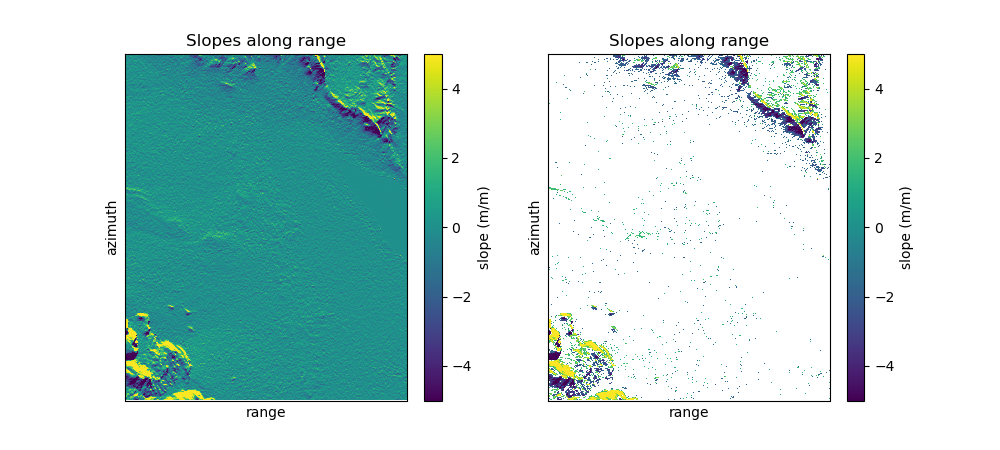

In [3]:
slopes_range = np.diff(elev_cropped,axis=0)
slopes_mask = np.ma.masked_inside(slopes_range,-1.4,1.4)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(slopes_range, cmap='viridis',interpolation='nearest',aspect='auto',vmin=-5,vmax=5); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Slopes along range'); plt.colorbar(label='slope (m/m)')
plt.subplot(1,2,2)
plt.imshow(slopes_mask, cmap='viridis',interpolation='nearest',aspect='auto',vmin=-5,vmax=5); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Slopes along range'); plt.colorbar(label='slope (m/m)')
plt.show()

In [4]:
# make a line diagonal across the area: NW to SE
x_test = np.arange(0,dx,1)
y_test = x_test*-0.275+1100
x_test_2 = [3140,3140]
y_test_2 = [0,240]

Mask it based on being below certain elevation. 

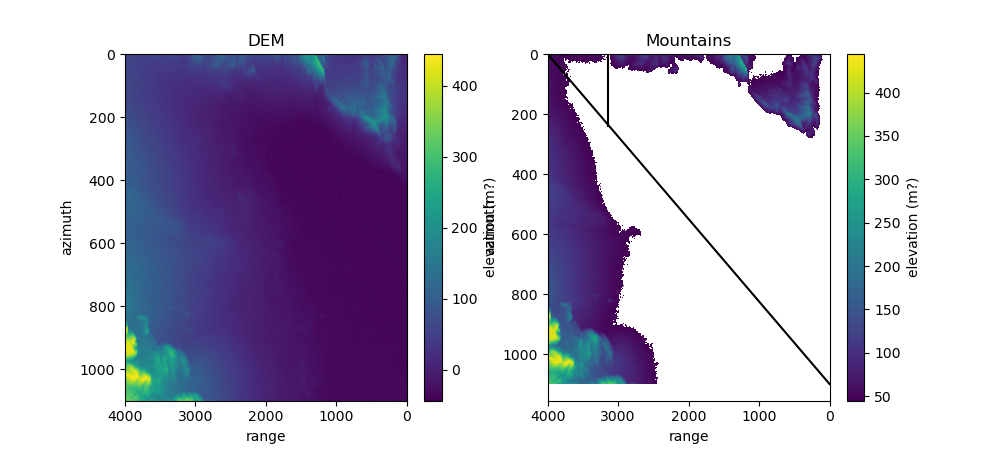

In [11]:
elev_th = 45
elev_masked_mtns = np.ma.masked_where(elev_cropped<elev_th,elev_cropped)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(elev_cropped, cmap='viridis',interpolation='nearest',aspect='auto'); plt.xlim(x1-x2,0); #plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('DEM'); plt.colorbar(label='elevation (m?)')
plt.subplot(1,2,2)
plt.imshow(elev_masked_mtns, cmap='viridis',interpolation='nearest',aspect='auto'); plt.xlim(x1-x2,0); #plt.xticks([]); plt.yticks([])
plt.plot(x_test,y_test,'k-')
plt.plot(x_test_2,y_test_2,'k-')
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Mountains'); plt.colorbar(label='elevation (m?)')
plt.show()

In [20]:
# loop through pixels, meet certain criteria to be considered mountains 
mtns = np.zeros((dy,dx))
for y in range(dy):
    for x in range(dx):
        if (x*-0.275+1100 > y) : # top right geographically 
            if (elev_cropped[y,x] > 45) and (x < 3140):
                mtns[y,x] = 1.0
        else: # bottom left geographically 
            if (elev_cropped[y,x] > 145):
                mtns[y,x] = 1.0
print('Mtn pixels assigned as 1s.')

Mtn pixels assigned as 1s.


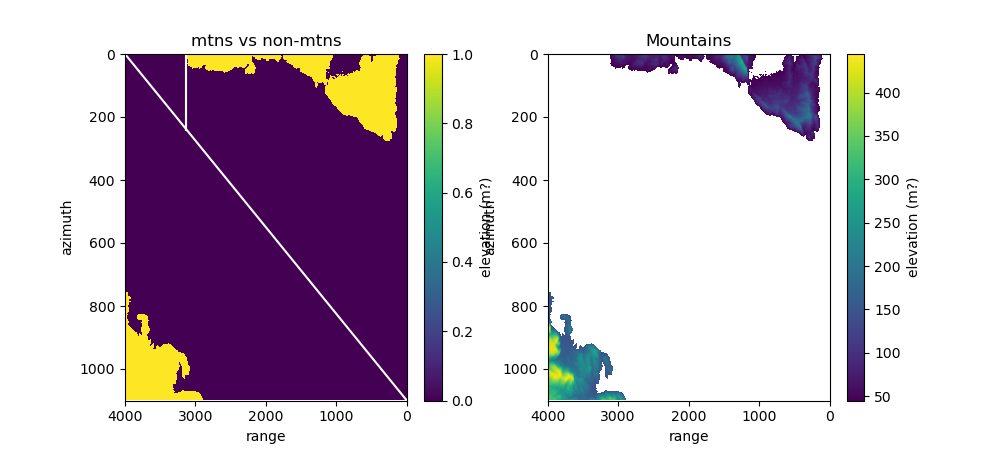

In [21]:
elev_masked_mtns = np.ma.masked_where(mtns==0,elev_cropped)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(mtns, cmap='viridis',interpolation='nearest',aspect='auto'); 
plt.xlim(x1-x2,0); plt.ylim(y1-y2,0)#plt.xticks([]); plt.yticks([])
plt.plot(x_test,y_test,'w-')
plt.plot(x_test_2,y_test_2,'w-')
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('mtns vs non-mtns'); plt.colorbar(label='elevation (m?)')
plt.subplot(1,2,2)
plt.imshow(elev_masked_mtns, cmap='viridis',interpolation='nearest',aspect='auto'); 
plt.xlim(x1-x2,0); plt.ylim(y1-y2,0)#plt.xticks([]); plt.yticks([])
# plt.plot(x_test,y_test,'k-')
# plt.plot(x_test_2,y_test_2,'k-')
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Mountains'); plt.colorbar(label='elevation (m?)')
plt.show()

Now make array to be saved as the mtns mask.

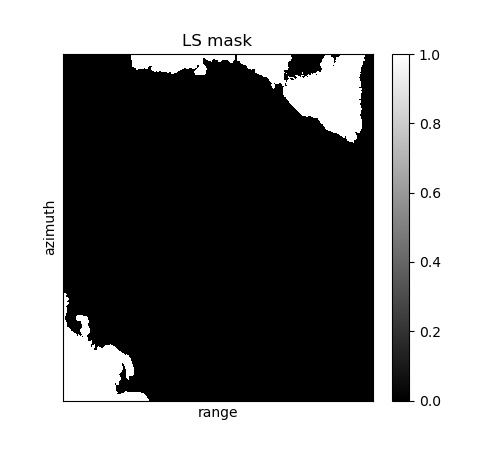

In [22]:
mask_y,mask_x = np.nonzero(elev_masked_mtns)
mtns_mask = np.zeros((dy,dx))
mtns_mask[mask_y,mask_x] = 1.0
#mtns_mask[400::,:] = 0.0

# plot it to make sure it matches plot above.
plt.figure(figsize=(5,4.5))
plt.imshow(mtns_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Mtns mask') 
plt.colorbar(); plt.show()

In [23]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# set the folder to save this mask file to
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/'
save_file_name = 'mtns_mask.r4'
colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(mtns_mask)
colds=None
print('Mask of mountains saved.')

Mask of mountains saved.
